In [1]:
import pandas as pd
import numpy as np
import sqlite3

In [2]:
# Подключаемся к БД
conn = sqlite3.connect('shop_database.db')
personal_data = pd.read_sql_query("SELECT * FROM personal_data", conn)
personal_data_coeffs = pd.read_sql_query("SELECT * FROM personal_data_coeffs", conn)
purchases = pd.read_sql_query("SELECT * FROM purchases", conn)
conn.close()


In [3]:
# Загружаем восстановленные данные
df_missing = pd.read_csv('personal_data.csv')


In [4]:
# Первые строки таблицы
df_missing.head()


,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


In [5]:
# Объединяем по id
personal_data_full = personal_data.combine_first(df_missing.set_index('id')).reset_index()


In [6]:
# Объединяем по столбцу 'id'
personal_full_with_coef = personal_data_full.merge(personal_data_coeffs, on='id', how='left')


In [7]:
# Объединяем по столбцу 'id'
merged_df = personal_full_with_coef.merge(purchases, on='id', how='left')


Для дальнейшего анализа объединили все таблицы: personal_data_full (данные о клиентах), personal_data_coeffs (коэффициенты клиентов) и purchases (информация о покупках). Это позволит нам работать с полной информацией о клиентах и их действиях. Объединенный датафрейм назвали merged_df.

In [8]:
merged_df.columns

Index(['index', 'age', 'city', 'country', 'education', 'gender', 'id',
       'lbt_coef', 'ac_coef', 'sm_coef', 'personal_coef', 'product', 'colour',
       'cost', 'product_sex', 'base_sale', 'dt'],
      dtype='object')

Проверяем что данные объединились.

In [9]:
personal_data_full.head()

,index,age,city,country,education,gender,id
0,0,36,1201,32,среднее,0.0,0.0
1,1,35,1134,32,среднее,0.0,4.0
2,2,52,1188,32,среднее,1.0,6.0
3,3,37,1198,32,среднее,0.0,7.0
4,4,48,1134,32,среднее,0.0,9.0


In [10]:
# Фильтрация по стране с кодом 32
personal_data = personal_data[personal_data['country'] == 32]


In [11]:
personal_data.shape


(88786, 6)

В отфильтрованной таблице осталось 88 786 клиентов, проживающих в стране с кодом 32.

Изминение данных о товарах и цветах

В этом блоке выполняется приведение названий товаров к единому формату — нижнему регистру и удалению лишних пробелов. Также очищены данные о цветах: если в поле `colour` указано несколько цветов.


In [12]:
purchases.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [13]:
# Изминение "/" на "," в строке colour 
purchases['colour'] = purchases['colour'].astype(str).str.replace('/', ', ').str.lower().str.strip()


In [14]:
# Приводим названия товаров к нижнему регистру и убираем лишние пробелы
purchases['product'] = purchases['product'].astype(str).str.lower().str.strip()


In [15]:
purchases.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"велосипед горный женский stern mira 2.0 26""","белый, синий",13599,0.0,1,7
1,0,стол outventure,зелёный,1499,NaN,0,37
2,0,набор outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,бутсы мужские gsd astro,белый,1599,1.0,0,13
4,3,мяч футбольный puma teamfinal 21.2 fifa qualit...,мультицвет,7199,NaN,0,27


Восстановление пропущенных значений в поле gender (Бинарная классификация)

В таблице df_missing отсутствует информация о поле gender. Мы обучим модель на тех данных, где gender присутствует (personal_data), и спрогнозируем пол для утерянных записей.

In [16]:
# Импорт необходимых библиотек
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [17]:
# Копия исходных данных
df_gender = personal_data.copy()

# Преобразуем категориальные признаки в числовые
df_gender['education'] = df_gender['education'].astype('category').cat.codes
X = df_gender.drop(columns=['id', 'gender'])
y = df_gender['gender']


In [18]:
# Разделим выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучим модель
model_gender = RandomForestClassifier(random_state=42)
model_gender.fit(X_train, y_train)

# Предсказание и отчёт
y_pred = model_gender.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.29      0.36     11311
           1       0.59      0.76      0.67     15325

    accuracy                           0.56     26636
   macro avg       0.53      0.53      0.51     26636
weighted avg       0.54      0.56      0.54     26636



In [19]:
# Преобразуем категориальные признаки в df_missing так же, как в обучающих данных
df_missing_copy = df_missing.copy()
df_missing_copy['education'] = df_missing_copy['education'].astype('category').cat.codes

In [20]:
# Предсказание
X_missing = df_missing_copy.drop(columns=['id'])
predicted_gender = model_gender.predict(X_missing)

In [21]:
# Добавим предсказания в таблицу
df_missing_copy['gender'] = predicted_gender

In [22]:
# Сохраняем полные данные с восстановленным полем gender
df_restored = df_missing.copy()
df_restored['gender'] = predicted_gender

Для построения модели мы использовали следующие признаки:
- возраст (`age`),
- образование (`education`),
- город проживания (`city`),
- страна (`country`).

Категориальный признак `education` был преобразован в числовой формат.

В качестве модели был выбран **RandomForestClassifier**, который показал следующие результаты на тестовой выборке:
- **Точность (accuracy)**: 0.56
- **Precision**: 0.47 (класс 0), 0.59 (класс 1)
- **Recall**: 0.29 (класс 0), 0.76 (класс 1)
- **F1-score**: 0.36 (класс 0), 0.67 (класс 1)
- 
После обучения модель была применена к данным `df_missing`, и в результате мы восстановили значения `gender` для 5 000 клиентов. Данные были сохранены в таблицу `df_restored`.

Ниже представлена первая строка восстановленных данных:

In [23]:
# Просмотр результата
df_restored.head()

,id,age,education,city,country,gender
0,101492,32,среднее,1188,32,1
1,42690,20,высшее,1134,32,1
2,113001,27,среднее,1187,32,1
3,163654,49,высшее,1160,32,1
4,69523,44,среднее,1137,32,0


Объединение данных:

    - Объединены `personal_data` и восстановленные строки `df_restored`.
    - Получен итоговый датафрейм `personal_data_full` с полем `gender` для всех клиентов.

In [24]:
# Убедимся, что оба датафрейма имеют одинаковую структуру
personal_data_full = pd.concat([personal_data, df_restored], ignore_index=True)


### A/B-тестирование

В этом этапе мы анализируем эффективность первой маркетинговой кампании, которая проводилась в период с 5 по 16 день. 

Для этого загружаем ID клиентов из двух групп:
- **Тестовая группа** (positive): клиенты, получившие персональную скидку.
- **Контрольная группа** (negative): клиенты со схожими характеристиками, но не получившие скидку.

Данные ID содержатся в отдельных текстовых файлах, структура которых требует предварительной обработки строк.

In [25]:
# Загрузка ID клиентов из файлов
with open("ids_first_company_negative.txt", encoding="utf-8") as f:
    line = f.readline()
    ids_str = line.replace("Ids of negative AB people ", "")
    negative_ids = pd.DataFrame({'id': list(map(int, ids_str.strip().split(";")))})

with open("ids_first_company_positive.txt", encoding="utf-8") as f:
    line = f.readline()
    ids_str = line.replace("Ids of positive AB people ", "")
    positive_ids = pd.DataFrame({'id': list(map(int, ids_str.strip().split(",")))})

In [26]:
# Фильтрация пользователей по группам
positive_group = purchases[purchases['id'].isin(positive_ids['id'])]
negative_group = purchases[purchases['id'].isin(negative_ids['id'])]

In [27]:
# Кампания шла с 5-го по 16-й день (включительно)
positive_group_campaign = positive_group[(positive_group['dt'] >= 5) & (positive_group['dt'] <= 16)]
negative_group_campaign = negative_group[(negative_group['dt'] >= 5) & (negative_group['dt'] <= 16)]


In [28]:
# Подсчёт уникальных покупателей, сделавших покупки в рамках кампании
positive_converted = positive_group_campaign['id'].nunique()
negative_converted = negative_group_campaign['id'].nunique()


In [29]:
# Общее число участников в каждой группе
positive_total = positive_ids['id'].nunique()
negative_total = negative_ids['id'].nunique()


In [30]:
# Конверсия
cr_positive = positive_converted / positive_total
cr_negative = negative_converted / negative_total
uplift = cr_positive - cr_negative


In [31]:
# Вывод результатов
print(f"Конверсия положительной группы: {cr_positive:.4f}")
print(f"Конверсия контрольной группы: {cr_negative:.4f}")
print(f"Uplift: {uplift:.4f}")

Конверсия положительной группы: 0.9739
Конверсия контрольной группы: 1.0000
Uplift: -0.0261


Мы провели анализ, сравнив конверсию среди клиентов, получивших персональную скидку, и контрольной группы, не получившей её.

**Период кампании:** с 5 по 16 день (включительно).

**Конверсия:**
- **Положительная группа (получили скидку):** 97.39%
- **Контрольная группа (не получили скидку):** 100%

**Uplift:** -2.61 процентных пункта.


#### Вывод:
Несмотря на предоставленную персональную скидку, пользователи в экспериментальной группе покупали немного **реже**, чем в контрольной.  
Это говорит о том, что **скидка не оказала положительного влияния на поведение клиентов**. Возможно, клиенты и так были готовы купить товар, и дополнительная скидка не была мотивирующим фактором.

**Рекомендация:** отказаться от массовой персональной рассылки скидок, если её эффективность не превышает контрольную группу. Предложить альтернативные гипотезы или сегментировать аудиторию точнее.

### Кластеризация клиентов:

In [32]:
# Импорт нужных библиотек
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Группируем данные по клиенту
client_data = merged_df.groupby('id').agg({
    'age': 'mean',
    'personal_coef': 'mean',
    'cost': 'mean',
    'base_sale': 'mean'
}).reset_index()

In [35]:
# Удалим строки с пропусками
client_data = client_data.dropna()

In [36]:
# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(client_data[['age', 'personal_coef', 'cost', 'base_sale']])

In [37]:
# Подбор числа кластеров — обнуляем inertia
inertia = []  
cluster_range = range(1, 10)

# Подбор числа кластеров (метод локтя)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

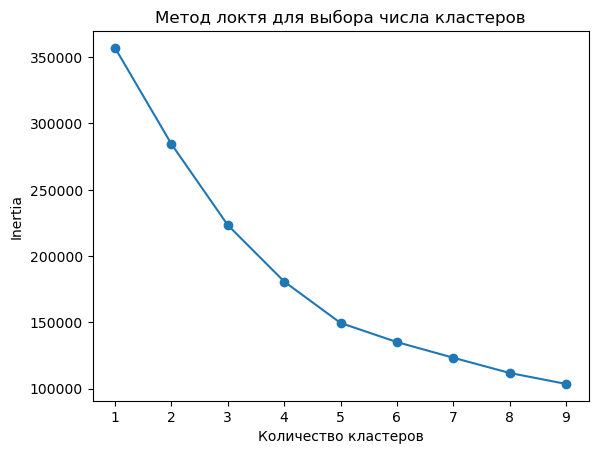

In [38]:
# График
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для выбора числа кластеров')
plt.show()

In [39]:
# Обучаем модель кластеризации
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)


In [40]:
# Создаем DataFrame с id и номером кластера
client_data['cluster'] = clusters


In [41]:
# Присоединяем информацию о кластере обратно к основной таблице
merged_df = merged_df.merge(client_data[['id', 'cluster']], on='id', how='left')


Для сегментации клиентов была выполнена кластеризация с использованием алгоритма KMeans:

- Были выбраны признаки: `age`, `personal_coef`, `cost`, `base_sale`.
- Данные агрегированы по клиенту и масштабированы с помощью `StandardScaler`.
- С помощью метода локтя определено оптимальное число кластеров — **4**.

### Визуализация кластеров

In [42]:
from sklearn.decomposition import PCA

In [43]:
# Уменьшим размерность до 2D для визуализации
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

In [44]:
# Создаем DataFrame для визуализации
vis_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
vis_df['cluster'] = clusters


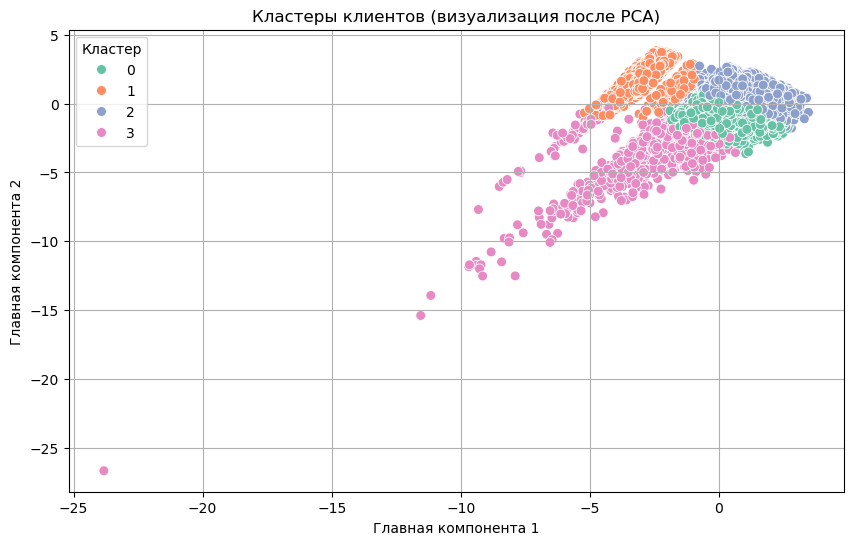

In [45]:
# Визуализация
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vis_df, x='PC1', y='PC2', hue='cluster', palette='Set2', s=50)
plt.title('Кластеры клиентов (визуализация после PCA)')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend(title='Кластер')
plt.grid(True)
plt.show()

### Визуализация кластеров

Для визуализации результатов кластеризации была применена методика понижения размерности — Principal Component Analysis (PCA), которая позволила отобразить многомерные данные в двумерном пространстве.

На основе результатов кластеризации клиенты были распределены по четырём группам и представлены на графике в виде точек, окрашенных в разные цвета. Это помогло наглядно оценить различия между кластерами и выявить их особенности.


### Построения модели склонности клиента к покупке:

In [46]:
# Выбираем нужные признаки
model_data = merged_df[['id', 'age', 'personal_coef', 'cost', 'base_sale']].copy()


In [47]:
# Удаляем строки с пропусками
model_data = model_data.dropna()


In [48]:
# Целевой признак — наличие покупки (1, если покупка была, 0 — если нет)
# Предположим, что base_sale > 0 означает покупку
model_data['target'] = model_data['base_sale'].apply(lambda x: 1 if x > 0 else 0)


In [49]:
# Удаляем ненужные признаки
model_data = model_data.drop(columns=['base_sale'])


In [50]:
# Проверим размер итогового набора
model_data.shape


(669956, 5)

In [51]:
# Посмотрим, сколько положительных и отрицательных примеров
model_data['target'].value_counts()

target
0    430950
1    239006
Name: count, dtype: int64

Обучение модели для предсказания склонности к покупке

In [52]:
# Импорт библеотек
from sklearn.metrics import roc_auc_score


In [53]:
# Разделим на признаки и целевую переменную
X = model_data.drop(columns=['target'])
y = model_data['target']


In [54]:
# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
# Обучим модель случайного леса
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train);


In [56]:
# Предсказания
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [57]:
# Оценка модели
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81     86246
           1       0.66      0.60      0.63     47746

    accuracy                           0.75    133992
   macro avg       0.73      0.72      0.72    133992
weighted avg       0.75      0.75      0.75    133992

ROC AUC: 0.7995601817350505


Для оценки модели использовались стандартные метрики качества:

- **Accuracy (точность):**  
      75% — модель правильно классифицирует 3 из 4 случаев.

- **Recall (полнота):**  
  - **Класс 0 (не совершили покупку):** 83% — большинство "некупивших" клиентов определены верно.  
  - **Класс 1 (совершили покупку):** 60% — около 60% "купивших" клиентов распознаны верно.

- **F1-мера:**  
  - **Класс 0:** 0.81  
  - **Класс 1:** 0.63 — заметно ниже, что указывает на трудности модели в определении клиентов, совершивших покупку.

- **ROC AUC:**  
      **0.80** — модель хорошо различает классы и обладает высоким дискриминирующим потенциалом.

### Вывод:
Модель работает неплохо, особенно в выявлении клиентов, **не совершивших покупку**. Однако есть пространство для **улучшения в распознавании положительного класса (покупка)**.


### Визуализация

In [58]:
# Получаем важности признаков
importances = model.feature_importances_


In [59]:
# Названия признаков 
feature_names = X_train.columns


In [60]:
# Создаем DataFrame с важностями
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)


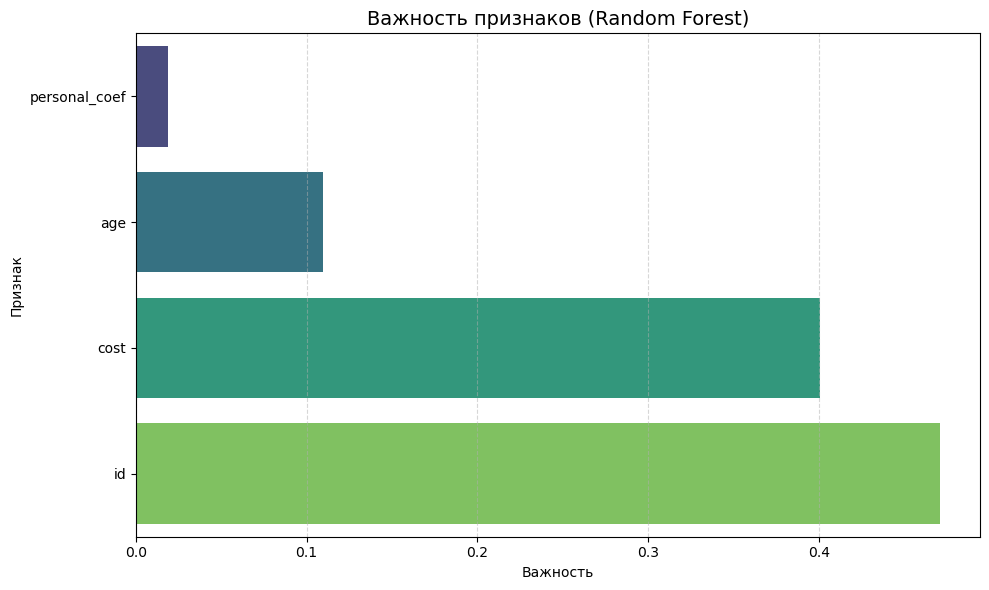

In [61]:
# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feature_importance_df,
    palette='viridis',
    legend=False
)
plt.title('Важность признаков (Random Forest)', fontsize=14)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()